In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

读取测试集上的预测结果文件

In [5]:
data_lr = pd.read_csv("test_pred_lr.csv")
data_mlp = pd.read_csv("test_pred_mlp.csv")
data_rf = pd.read_csv("test_pred_rf.csv")

# 线性回归模型分析
首先选取了4个评价指标MSE，RMSE，MAE以及SMPAE来对模型进行评价，评价指标如下所示

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

def mse(y_true,y_pred):
    return metrics.mean_squared_error(y_true, y_pred)

def rmse(y_true,y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

def mae(y_true,y_pred):
    return metrics.mean_absolute_error(y_true, y_pred)

In [6]:
y_true_lr = data_lr['winPlacePerc']
y_pred_lr = data_lr['pred_winPlacePerc']

mse_lr = mse(y_true_lr,y_pred_lr)
rmse_lr = rmse(y_true_lr,y_pred_lr)
mae_lr = mae(y_true_lr,y_pred_lr)
smape_lr = smape(y_true_lr,y_pred_lr)

print("MSE : ",mse_lr)
print("RMSE : ",rmse_lr)
print("MAE : ",mae_lr)
print("SMAPE : ",smape_lr)

MSE :  0.015967550089728166
RMSE :  0.12636277177130995
MAE :  0.09222107817896855
SMAPE :  35.659626765502075


从中可以看到，线性回归模型存在着一定误差，首先选取前100个数据将真实值和预测值绘制成折线图，观察真实值与预测值之间的差距，如下图所示

In [10]:
def zhe(y_true,y_pred,title):
    t = np.arange(len(y_true[:100]))
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    plt.plot(t, y_true[:100], "r-", linewidth=2, label="true")
    plt.plot(t, y_pred[:100], "g-", linewidth=2, label="predict")
    plt.title(title, fontsize=24)
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

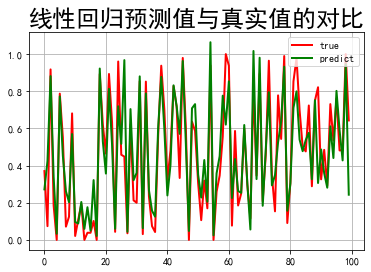

In [57]:
zhe(y_true_lr,y_pred_lr,"线性回归预测值与真实值的对比")

红色折线代表真实值，绿色折线代表预测值，从中可以发现，当真实值的胜率偏大时，预测值低于真实值，然而当真实值的胜率偏低时，预测值高于真实值，这说明当利用线性回归模型进行预测时，预测的数字偏于稳定。

In [9]:
def true_pred(y_true,y_pred,title):
    plt.figure("scatter")
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    plt.title(title, fontsize=24)
    x = np.arange(0, 1,0.01)
    y = x
    plt.plot(x, y)
    plt.xlabel("真实值", fontsize=14)
    plt.ylabel("预测值", fontsize=14)
    plt.scatter(y_true, y_pred, color='green', label='Test')
    plt.grid(linestyle=":")
    plt.show()

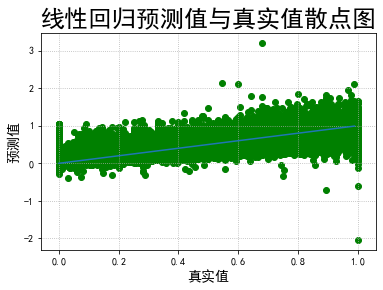

In [10]:
true_pred(y_true_lr,y_pred_lr,"线性回归预测值与真实值散点图")

In [11]:
i = 0
lis = list(data_lr.columns)
data_lr_values = data_lr.values
error_data_lr = []
for tmp in data_lr_values:
    if tmp[len(tmp)-1] >1 or tmp[len(tmp)-1]<0:
        error_data_lr.append(tmp)
print(len(error_data_lr))

18292


从散点图中可以发现，线性回归模型的预测值并没有很好的拟合真实值，甚至与概率学相违背，即在预测时出现了预测值大于1以及小于0的情况。通过统计发现总共有18292个离奇的预测值，将这些数据单拿出来，观察真实值和预测值之间相关系数有何不同？绘制出相关系数的热力图如下所示

<Figure size 14400x21600 with 0 Axes>

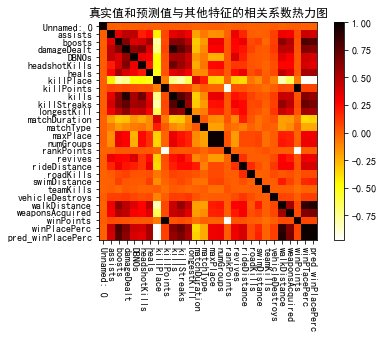

In [14]:
plt.figure(figsize=(200, 300))
xLabel = lis
yLabel = lis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yticks(range(len(yLabel)))
ax.set_yticklabels(yLabel)
ax.set_xticks(range(len(xLabel)))
ax.set_xticklabels(xLabel)
im = ax.imshow(pd.DataFrame(error_data_lr).corr(), cmap=plt.cm.hot_r)
plt.colorbar(im)
plt.xticks(rotation=270)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.title("真实值和预测值与其他特征的相关系数热力图")
plt.show()

通过观察发现，主要集中在boosts（饮料数量），kills（杀敌数），killStreak（连续杀敌数.）以及demageDealt（总伤害）.这4个特征的真实值与预测值之间的相关系数存在着较大差异。在预测真实值中观察相关系数会发现，winPlacePerc（获胜概率）与walkDistance（步行距离），weaponsAcquired（武器收集数量），boosts（饮料数量）相关度最高。这说明在线性回归模型学习的过程中，对boosts（饮料数量）的学习不充分，导致结果出现了异常情况。

In [28]:
e_boosts = []
e_y_true = []
e_y_pred = []
for tmp in error_data_lr:
    e_boosts.append(tmp[1])
    e_y_pred.append(tmp[len(tmp)-1])
    e_y_true.append(tmp[len(tmp)-2])

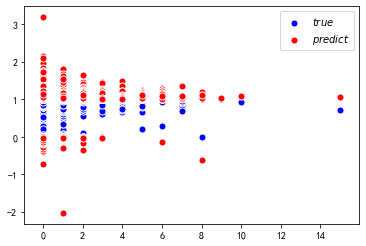

In [30]:
plt.scatter(e_boosts,e_y_true, s=200, label = '$true$', c = 'blue', marker='.', alpha = None, edgecolors= 'white')
plt.scatter(e_boosts,e_y_pred , s=200, label = '$predict$', c = 'red', marker='.', alpha = None, edgecolors= 'white')
plt.legend()

在图中可以观察到，大部分的预测值都是高于真实值的，从图中可以看到在boosts为0的时候，预测有很大的偏差。

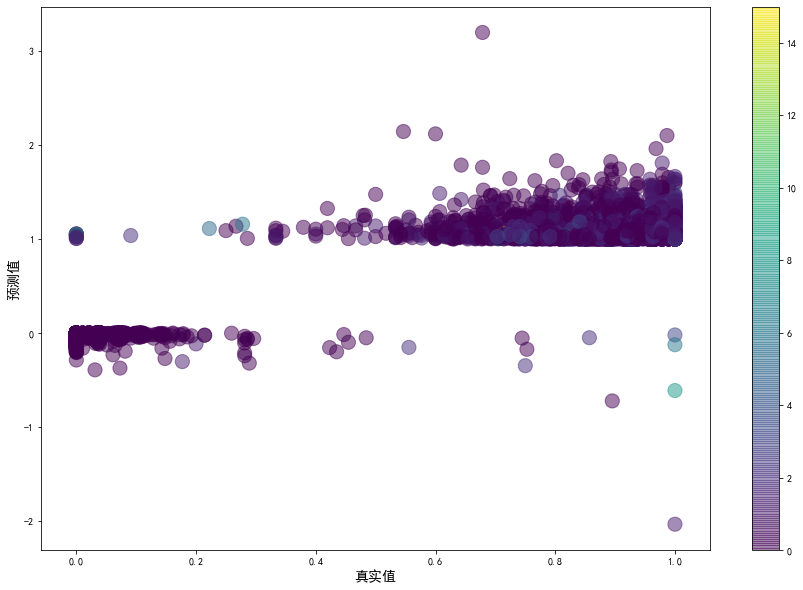

In [55]:
plt.figure(figsize=(15,10))
plt.scatter(e_y_true,e_y_pred,alpha=0.5,s=200,c=e_boosts)
plt.xlabel("真实值", fontsize=14)
plt.ylabel("预测值", fontsize=14)
plt.colorbar()

从图中可以发现，当真实值为1时，boosts为6时出现了预测值小于0的情况，在真实值为0，预测值普遍低于0，同时boosts大多数为0，也就是说在线性回归模型中，较小的真实值和较大的真实值在预测时容易出现错误。

# MLP模型分析

In [7]:
y_true_mlp = data_mlp['winPlacePerc']
y_pred_mlp = data_mlp['pred_winPlacePerc']

mse_mlp = mse(y_true_mlp,y_pred_mlp)
rmse_mlp = rmse(y_true_mlp,y_pred_mlp)
mae_mlp = mae(y_true_mlp,y_pred_mlp)
smape_mlp = smape(y_true_mlp,y_pred_mlp)

print("MSE : ",mse_mlp)
print("RMSE : ",rmse_mlp)
print("MAE : ",mae_mlp)
print("SMAPE : ",smape_mlp)

MSE :  0.006853608716019664
RMSE :  0.08278652496644405
MAE :  0.06068561942319822
SMAPE :  27.886112150587223


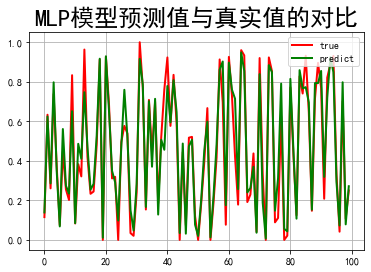

In [58]:
zhe(y_true_mlp,y_pred_mlp,"MLP模型预测值与真实值的对比")

通过观察可以发现，在折线图的对比中，MLP模型的真实值和预测值之间的差距明显比线性回归模型小很多，同时真实值往往会大于预测值。

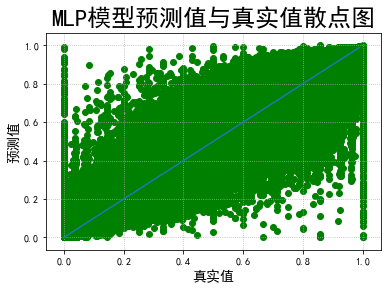

In [20]:
true_pred(y_true_mlp,y_pred_mlp,"MLP模型预测值与真实值散点图")

在MLP模型的预测值和真实值的散点图中可以发现，它的分布像一个树叶，部分的数据有很好的预测结果，但是可以发现在真实值为1时，预测值有的结果接近于0，同时在真实值为0时，预测也存在接近于1的情况,我们选取所有真正值与预测值大于0.5的数据。

In [68]:
data_mlp_values = data_mlp.values
error_data_mlp = []
e_y_true_mlp = []
e_y_pred_mlp = []
for tmp in data_mlp_values:
    if abs(tmp[len(tmp)-1]-tmp[len(tmp)-2])>0.5:
        error_data_mlp.append(tmp)
        e_y_true_mlp.append(tmp[len(tmp)-2])
        e_y_pred_mlp.append(tmp[len(tmp)-1])
print(len(error_data_mlp))

314


通过统计发现，真实值与预测值出现较大偏差的数据总共有314个。

Text(0, 0.5, '预测值')

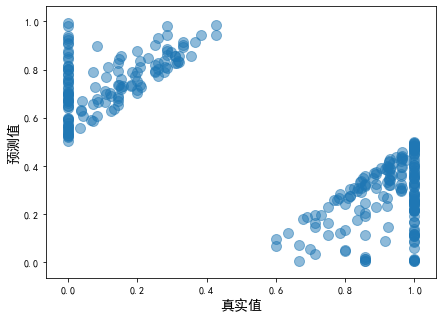

In [69]:
plt.figure(figsize=(7,5))
plt.scatter(e_y_true_mlp,e_y_pred_mlp,alpha=0.5,s=100)
plt.xlabel("真实值", fontsize=14)
plt.ylabel("预测值", fontsize=14)

在散点图中可以看到，主要在真实值接近于0和真实值接近于1的位置出现的预测失误最大。

# 随机森林模型分析

In [8]:
y_true_rf = data_rf['winPlacePerc']
y_pred_rf = data_rf['pred_winPlacePerc']

mse_rf = mse(y_true_rf,y_pred_rf)
rmse_rf = rmse(y_true_rf,y_pred_rf)
mae_rf = mae(y_true_rf,y_pred_rf)
smape_rf = smape(y_true_rf,y_pred_rf)

print("MSE : ",mse_rf)
print("RMSE : ",rmse_rf)
print("MAE : ",mae_rf)
print("SMAPE : ",smape_rf)

MSE :  0.006729683971475941
RMSE :  0.08203465104134923
MAE :  0.058137953677406866
SMAPE :  26.446352883656203


通过选取三个评价指标可以发现，随机森林的在各个指标下取得了良好的结果

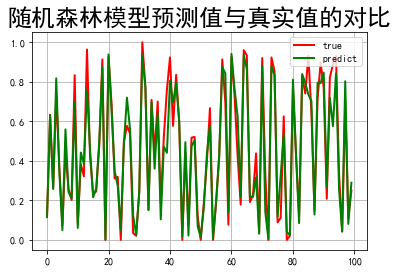

In [59]:
zhe(y_true_rf,y_pred_rf,"随机森林模型预测值与真实值的对比")

从图中可以发现，随机森林的预测值和真实值比较接近。

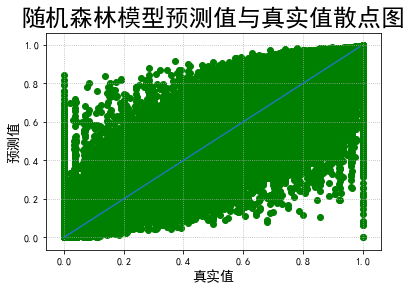

In [25]:
true_pred(y_true_rf,y_pred_rf,"随机森林模型预测值与真实值散点图")

在散点图中也可以观察到，在预测值和真实值的散点图中，相比比较于MLP，在真正值为0和1的部分，随机森林的效果比MLP要强，在之前的分析中探讨了三个模型MAE评价指标，这里又选取了其他3个指标，探讨随机森林模型是否真的为最优模型？

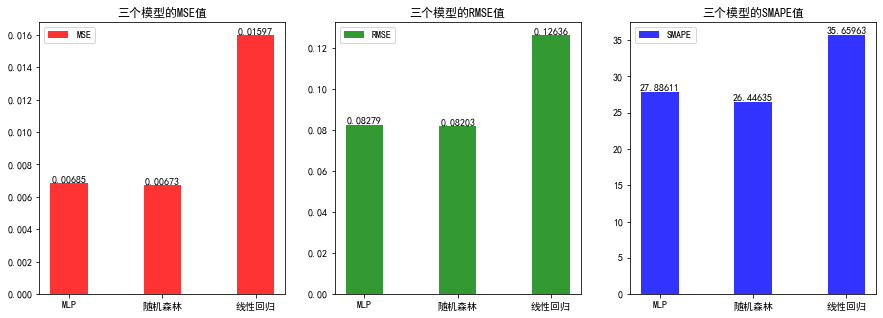

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(131)
label_list = ['MLP', '随机森林','线性回归']    
num_list1 = [mse_mlp,mse_rf,mse_lr]      
x = range(len(num_list1))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
rects1 = plt.bar(x =label_list , height=num_list1, width=0.4, alpha=0.8, color='red',label='MSE')
plt.xticks([index +0.0 for index in x], label_list)
plt.title("三个模型的MSE值")
plt.legend()    

for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2,height, str(round(height, 5)), ha="center", va="bottom")
    
plt.subplot(132)

label_list = ['MLP', '随机森林','线性回归']    
num_list1 = [rmse_mlp,rmse_rf,rmse_lr]      
x = range(len(num_list1))

rects1 = plt.bar(x =label_list , height=num_list1, width=0.4, alpha=0.8, color='green',label='RMSE')
plt.xticks([index +0.0 for index in x], label_list)
plt.title("三个模型的RMSE值")
plt.legend()    

for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2,height, str(round(height, 5)), ha="center", va="bottom")
    
# plt.subplot(223)

# label_list = ['MLP', '随机森林','线性回归']    
# num_list1 = [mae_mlp,mae_rf,mae_lr]      
# x = range(len(num_list1))

# rects1 = plt.bar(x =label_list , height=num_list1, width=0.4, alpha=0.8, color='yellow',label='MAE')
# plt.xticks([index +0.0 for index in x], label_list)
# plt.title("三个模型的MAE值")
# plt.legend()    

# for rect in rects1:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width() / 2,height, str(round(height, 5)), ha="center", va="bottom")

plt.subplot(133)
label_list = ['MLP', '随机森林','线性回归']    
num_list1 = [smape_mlp,smape_rf,smape_lr]      
x = range(len(num_list1))

rects1 = plt.bar(x =label_list , height=num_list1, width=0.4, alpha=0.8, color='blue',label='SMAPE')
plt.xticks([index +0.0 for index in x], label_list)
plt.title("三个模型的SMAPE值")
plt.legend()    

for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2,height, str(round(height, 5)), ha="center", va="bottom")

In [13]:
data_rf_values = data_rf.values
error_data_rf = []
e_y_true_rf = []
e_y_pred_rf = []
for tmp in data_rf_values:
    if abs(tmp[len(tmp)-1]-tmp[len(tmp)-2])>0.99:
        error_data_rf.append(tmp)
        e_y_true_rf.append(tmp[len(tmp)-2])
        e_y_pred_rf.append(tmp[len(tmp)-1])
print(len(error_data_rf))

2


In [15]:
data_mlp_values = data_mlp.values
eerror_data_mlp = []
ee_y_true_mlp = []
ee_y_pred_mlp = []
for tmp in data_mlp_values:
    if abs(tmp[len(tmp)-1]-tmp[len(tmp)-2])>0.99:
        eerror_data_mlp.append(tmp)
        ee_y_true_mlp.append(tmp[len(tmp)-2])
        ee_y_pred_mlp.append(tmp[len(tmp)-1])
print(len(eerror_data_mlp))

6


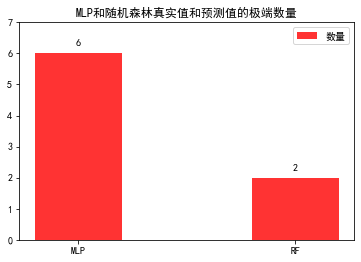

In [16]:
label_list = ['MLP', 'RF']    
num_list1 = [len(eerror_data_mlp), len(error_data_rf)]      
x = range(len(num_list1))

rects1 = plt.bar(x =label_list , height=num_list1, width=0.4, alpha=0.8, color='red',label='数量')
plt.ylim(0, 7)   
plt.xticks([index +0.0 for index in x], label_list)
plt.title("MLP和随机森林真实值和预测值的极端数量")
plt.legend()    

for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+0.2, str(height), ha="center", va="bottom")
plt.show()

假定真实值和预测值的差值为0.99以上为极端预测值，可以发现MLP模型的极端数量6远远大于随机森林的预测数量2，虽然随机森林模型也存在着一定误差，但是相比较之下，随机森林模型最适合解决PUBG玩家排名预测问题。